# Предварительный анализ трафиков.

**Цель проекта: изучить тарифы на предмет экономической эффективности.**

Входные данные: сведения о 500 пользователей и их использование сотовой связью.

**План работы:**
- изучение данных;
- предобработка данных;
- дополнительные расчеты в соответствии с заданием;
- объединение датафреймов;
- расчет расходов абонентов двух тарифов;
- анализ поведения абонентов двух тарифов (расчет дисперсии, стандартного отклонения, анализ гистаграмм);
- проверка гипотез;
- общий вывод.

## Шаг 1. Обзор данных

### Загружаем данные

Импортируем библиотеки Pandas, Numpy и метод scipy из библиотеки Stats

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

In [2]:
import matplotlib.pyplot as plt

Загружаем датафреймы
- users (информация о пользователях)
- calls (информация о звонках)
- messages (информация о смс)
- internet (информация об интернет-сессиях)
- tariffs (информация о тарифах)

In [3]:
users = pd.read_csv('/datasets/users.csv')

In [4]:
calls = pd.read_csv('/datasets/calls.csv')

In [5]:
messages = pd.read_csv('/datasets/messages.csv')

In [6]:
internet = pd.read_csv('/datasets/internet.csv')

In [7]:
tariffs = pd.read_csv('/datasets/tariffs.csv')

Снижает размерность чисел для вывода на экран на всем проекте:

In [8]:
pd.options.display.float_format = '{:,.2f}'.format

### Изучаем и подготавливаем данные

#### Датафрейм users (абоненты)

In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В данном датафрейме 500 строк (абонентов) и 8 столбцов. Пропуски имеются только в столбце `churn_date`, а согласно технической документации, это означает, что на момент выгрузки данный тариф действовал. 

In [10]:
display(users.head(10))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Преобразуем столбец `reg_date` из `object` в `datetime64`.

In [11]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


#### Датафрейм calls (звонки)

In [13]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В датафрейме 4 столбца и 202607 строк. Пропуски отсутствуют.

In [14]:
display(calls.head(5))

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Мы видим, что в столбце `duration` имеются нулевые значения. Согласно технической документации это пропущенные звонки.

Меняем тип данных столбеца `call_date` из `object` в `datetime64`.

In [15]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [16]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


#### Датафрейм internet (интернет-трафик)

In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В датафрейме 4 столбца и 149396 строк. Пропуски отсутствуют.

In [18]:
display(internet.head(5))

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [19]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

#### Датафрейм messages (смс-сообщения)

In [20]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В датафрейме 3 столбца и 123036 строк. Пропуски отсутствуют.

In [21]:
display(messages.head(5))

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [22]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

#### Датафрейм tariffs (тариф)

In [23]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В датафрейме 8 столбцов и 2 строки. Пропуски отсутствуют.

In [24]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Стоит обратить внимание, что расчет за интернет-трафик происходит за гигабайт, а в датафрейме указаны данные за мегабайты. Добавим дополнительный столбец `gb_per_month_included` с расчетом тарифа в гигабайтах:

In [25]:
tariffs['gb_per_month_included'] = (tariffs['mb_per_month_included'] / 1024).apply(np.ceil).astype(int)

Наименование столбца `tariff_name` в датафрейме `tariffs` отличается от наименования столбца в датафрейме `users`. Стоит сразу заменить, чтобы в дальнейшем было объединить:

In [26]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

In [27]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15
1,1000,30720,3000,1950,150,1,1,ultra,30


### Осуществляем дополнительные вычисления в соответствии с заданием.

В датафрейме `calls` добавляем столбец с расчетом звонков в минутах. Согласно технической документации время звонков указано в минутах, но согласно тарифному плану время округляется до целых минут по каждому звонку отдельно.

Создаем столбец `calls_ceil`

In [28]:
calls['duration_ceil'] = np.ceil(calls['duration']).astype(int)

Добавляем столбец с номером месяца:

In [29]:
calls['month'] = calls['call_date'].dt.month

Проверяем:

In [30]:
display(calls.head(5))

,id,call_date,duration,user_id,duration_ceil,month
0,1000_0,2018-07-25,0.00,1000,0,7
1,1000_1,2018-08-17,0.00,1000,0,8
2,1000_2,2018-06-11,2.85,1000,3,6
3,1000_3,2018-09-21,13.80,1000,14,9
4,1000_4,2018-12-15,5.18,1000,6,12


Группируем данные по столбцам `user_id` и `month`, считаем сумму звонков за месяц и их количество. Обязательно обновляем индексацию:

In [31]:
calls_group = calls.pivot_table(index=['user_id','month'], values='duration_ceil', aggfunc=['sum', 'count']).reset_index()

Меняем наименование столбцов:

In [32]:
calls_group.columns = ['user_id', 'month', 'duration_sum', 'duration_count']

Проверяем:

In [33]:
display(calls_group.head(5))

,user_id,month,duration_sum,duration_count
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


В датафрейме `internet` добавляем столбец с порядковым месяцем:

In [34]:
internet['month'] = internet['session_date'].dt.month

Группируем по столбцам user_id и month, считаем количество израсходованного трафика по месяцам:

In [35]:
internet_group = internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc=['sum', 'count']).reset_index()

Меняем наименование столбцов:

In [36]:
internet_group.columns = ['user_id', 'month', 'mb_user_sum', 'mb_user_count']

Согласно тарифному плану расчет использованного интернет-трафика осуществляется как общая сумма за месяц в гигабайтах, с округлением в большую сторону. Создаем столбец `gb_user_sum` в котором расчитаем трафик разделив количество мегабайт на 1024 до целого числа:

In [37]:
internet_group['gb_user_sum'] = (internet_group['mb_user_sum'] / 1024).apply(np.ceil).astype(int)

Проверяем:

In [38]:
display(internet_group.head(5))

,user_id,month,mb_user_sum,mb_user_count,gb_user_sum
0,1000,5,"2,253.49",5,3
1,1000,6,"23,233.77",49,23
2,1000,7,"14,003.64",29,14
3,1000,8,"14,055.93",29,14
4,1000,9,"14,568.91",27,15


В датафрейме `messages` добавляем столбец с порядковым месяцем:

In [39]:
messages['month'] = messages['message_date'].dt.month

Группируем по столбцам user_id и month, считаем количество израсходованного трафика по месяцам:

In [40]:
messages_group = messages.pivot_table(index=['user_id','month'], values='id', aggfunc='count').reset_index()

Меняем наименование столбцов:

In [41]:
messages_group.columns = ['user_id', 'month', 'messages_count']

Проверяем:

In [42]:
display(messages_group.head(5))

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Вывод:

В результате проделанной работы:
- загружены и проверены 5 датафреймов со сведениями об абонентах, их активности (звонки, сообщения и интернет-трафиках) и имеющихся трафиках;
- проведена предобработка данных:
   * изменен тип данных, содержащих данные о датах,
   * добавлены столбцы, содержащие сведение о месяце;
   * пересчитаны сведения о минутах до целых чисел (округление в сторону увеличения);
   * в датафрейме тарифов мегабайты переведены в гигабайты;
- созданы датафреймы содержащие сгруппированные сведения звонках, смс-сообщениях и израсходованных мегабайтах за месяц по каждому пользователю;
- мегабайты израсходованные за месяц переведены в гигабайты с округлением в сторону увеличесния.

## Объединение датафреймов

Слияние столбцов:

In [43]:
data = (calls_group.merge(messages_group, on=['user_id', 'month'], how='outer')
             .merge(internet_group, on=['user_id', 'month'], how='outer')
             .merge(users, on='user_id',how='outer'))

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3216 non-null   int64         
 1   month           3214 non-null   float64       
 2   duration_sum    3174 non-null   float64       
 3   duration_count  3174 non-null   float64       
 4   messages_count  2717 non-null   float64       
 5   mb_user_sum     3203 non-null   float64       
 6   mb_user_count   3203 non-null   float64       
 7   gb_user_sum     3203 non-null   float64       
 8   age             3216 non-null   int64         
 9   churn_date      189 non-null    object        
 10  city            3216 non-null   object        
 11  first_name      3216 non-null   object        
 12  last_name       3216 non-null   object        
 13  reg_date        3216 non-null   datetime64[ns]
 14  tariff          3216 non-null   object        
dtypes: d

In [45]:
display(data.head(5))

,user_id,month,duration_sum,duration_count,messages_count,mb_user_sum,mb_user_count,gb_user_sum,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5.00,159.00,22.00,22.00,"2,253.49",5.00,3.00,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6.00,172.00,43.00,60.00,"23,233.77",49.00,23.00,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7.00,340.00,47.00,75.00,"14,003.64",29.00,14.00,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8.00,408.00,52.00,81.00,"14,055.93",29.00,14.00,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9.00,466.00,58.00,57.00,"14,568.91",27.00,15.00,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Два абонента подключились во второй половине декабря и не воспользовались сотовой связью, все данные нулевые. Их можно удалить.

<div class="alert alert-anger">
<font size="4"><b>❌ Комментарий ревьюера ✔️</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Данные абоненты принесли выручку компании, нельзя их просто удалить.

Точность в расчетах с выручкой и параметрами, которые связаны с деньгами должна быть 100%

In [46]:
data = data.dropna(subset=['month']).reset_index()

Остальные пропуски можно заменить на 0. Эти пропуски могли появиться, если абонент в тот или иной месяц не пользовался интернетом, не звонил или не писал смс:

In [47]:
data['duration_sum'] = data['duration_sum'].fillna(0)
data['duration_count'] = data['duration_count'].fillna(0)
data['messages_count'] = data['messages_count'].fillna(0)
data['mb_user_sum'] = data['mb_user_sum'].fillna(0)
data['mb_user_count'] = data['mb_user_count'].fillna(0)
data['gb_user_sum'] = data['gb_user_sum'].fillna(0)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           3214 non-null   int64         
 1   user_id         3214 non-null   int64         
 2   month           3214 non-null   float64       
 3   duration_sum    3214 non-null   float64       
 4   duration_count  3214 non-null   float64       
 5   messages_count  3214 non-null   float64       
 6   mb_user_sum     3214 non-null   float64       
 7   mb_user_count   3214 non-null   float64       
 8   gb_user_sum     3214 non-null   float64       
 9   age             3214 non-null   int64         
 10  churn_date      187 non-null    object        
 11  city            3214 non-null   object        
 12  first_name      3214 non-null   object        
 13  last_name       3214 non-null   object        
 14  reg_date        3214 non-null   datetime64[ns]
 15  tari

## Расчет расходов абонентов

In [49]:
data_good = data[['user_id', 'month', 'duration_sum', 'messages_count', 'gb_user_sum', 'city', 'tariff']]

In [50]:
data_good = data_good.merge(tariffs, on='tariff', how='outer')

In [51]:
data_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   float64
 2   duration_sum           3214 non-null   float64
 3   messages_count         3214 non-null   float64
 4   gb_user_sum            3214 non-null   float64
 5   city                   3214 non-null   object 
 6   tariff                 3214 non-null   object 
 7   messages_included      3214 non-null   int64  
 8   mb_per_month_included  3214 non-null   int64  
 9   minutes_included       3214 non-null   int64  
 10  rub_monthly_fee        3214 non-null   int64  
 11  rub_per_gb             3214 non-null   int64  
 12  rub_per_message        3214 non-null   int64  
 13  rub_per_minute         3214 non-null   int64  
 14  gb_per_month_included  3214 non-null   int64  
dtypes: f

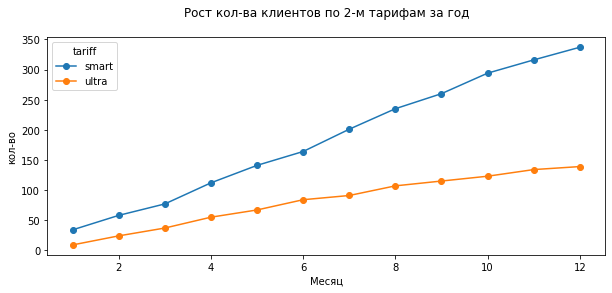

In [52]:
(data_good
 .pivot_table(index='tariff', columns='month', values='user_id', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Рост кол-ва клиентов по 2-м тарифам за год'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('кол-во');

Согласно данных графика можно сделать вывод, что общее количество абонентов, подключивших изучаемые тарифы, растет, но у тарифа Смарт динамика роста активнее.

In [53]:
print('Количество абонентов на тарифе Смарт, которые не использовали минуты:',
       data_good.query('tariff == "smart" and duration_sum == 0')['user_id'].count())
print('Количество абонентов на тарифе Смарт, которые не использовали смс:', 
      data_good.query('tariff == "smart" and messages_count == 0')['user_id'].count())
print('Количество абонентов на тарифе Смарт, которые не использовали ГБ:', 
      data_good.query('tariff == "smart" and mb_per_month_included == 0')['user_id'].count())
print('Количество абонентов на тарифе Ультра, которые не использовали минуты:',
       data_good.query('tariff == "ultra" and duration_sum == 0')['user_id'].count())
print('Количество абонентов на тарифе Ультра, которые не использовали смс:', 
      data_good.query('tariff == "ultra" and messages_count == 0')['user_id'].count())
print('Количество абонентов на тарифе Ультра, которые не использовали ГБ:', 
      data_good.query('tariff == "ultra" and mb_per_month_included == 0')['user_id'].count())

Количество абонентов на тарифе Смарт, которые не использовали минуты: 8
Количество абонентов на тарифе Смарт, которые не использовали смс: 307
Количество абонентов на тарифе Смарт, которые не использовали ГБ: 0
Количество абонентов на тарифе Ультра, которые не использовали минуты: 38
Количество абонентов на тарифе Ультра, которые не использовали смс: 190
Количество абонентов на тарифе Ультра, которые не использовали ГБ: 0


In [54]:
def minutes(row):
    mes = row['duration_sum'] - row['minutes_included']
    if row['duration_sum'] < row['minutes_included']:
        return 0
    return mes

In [55]:
data_good['lot_minutes'] = data_good.apply(minutes, axis=1)

In [56]:
def messages(row):
    mes = row['messages_count'] - row['messages_included']
    if row['messages_count'] < row['messages_included']:
        return 0
    return mes

In [57]:
data_good['lot_messages'] = data_good.apply(messages, axis=1)

In [58]:
def internet(row):
    mes = row['gb_user_sum'] - row['gb_per_month_included']
    if row['gb_user_sum'] < row['gb_per_month_included']:
        return 0
    return mes

In [59]:
data_good['lot_internet'] = data_good.apply(internet, axis=1)

In [60]:
data_good['lot_sum'] = data_good['lot_minutes']*data_good['rub_per_minute'] + data_good['lot_messages']*data_good['rub_per_message'] + data_good['lot_internet']*data_good['rub_per_gb']
data_good['general_sum'] = data_good['lot_sum'] + data_good['rub_monthly_fee']


In [61]:
display(data_good.head(5))

,user_id,month,duration_sum,messages_count,gb_user_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,lot_minutes,lot_messages,lot_internet,lot_sum,general_sum
0,1000,5.00,159.00,22.00,3.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,0.00,0.00,0.00,0.00,"1,950.00"
1,1000,6.00,172.00,60.00,23.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,0.00,0.00,0.00,0.00,"1,950.00"
2,1000,7.00,340.00,75.00,14.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,0.00,0.00,0.00,0.00,"1,950.00"
3,1000,8.00,408.00,81.00,14.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,0.00,0.00,0.00,0.00,"1,950.00"
4,1000,9.00,466.00,57.00,15.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,0.00,0.00,0.00,0.00,"1,950.00"


In [62]:
data_good_group = data_good.groupby('tariff').agg(
    ({'month': 'count', 'rub_monthly_fee': 'sum', 'lot_sum': ['mean', 'sum'],
      'general_sum': ['mean', 'sum'], 'duration_sum': 'mean', 'messages_count': 'mean',
     'gb_user_sum': 'mean'})) #группируем по тарифам

data_good_group.columns = (['month_count', 'rub_free_sum', 'lot_sum_mean',
                            'lot_sum', 'general_sum_mean', 'general_sum', 'duration_mean',
                            'messages_mean', 'gb_user_mean']) # переименовываем столбцы

# округляем данные в столбцах до целого числа в сторону увеличения

data_good_group = np.ceil(data_good_group).astype(int)

display(data_good_group)

,month_count,rub_free_sum,lot_sum_mean,lot_sum,general_sum_mean,general_sum,duration_mean,messages_mean,gb_user_mean
tariff,,,,,,,,,
smart,2229,1225950,740,1649401,1290,2875351,418,34,17
ultra,985,1920750,121,118350,2071,2039100,527,50,20


In [63]:
print('Количество превышений по тарифу SMART', data_good[(data_good['lot_sum'] > 0) & (data_good['tariff'] == 'smart')]['lot_sum'].count())
print('Количество превышений по тарифу SMART', data_good[(data_good['lot_sum'] > 0) & (data_good['tariff'] == 'ultra')]['lot_sum'].count())

Количество превышений по тарифу SMART 1662
Количество превышений по тарифу SMART 134


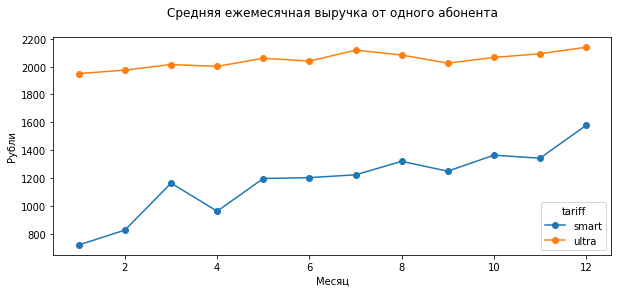

In [64]:
(data_good
 .pivot_table(index='tariff', columns='month', values='general_sum', aggfunc='mean')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Средняя ежемесячная выручка от одного абонента'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли');

In [65]:
print('Общая сумма дохода по тарифу SMART', 2875351, ', доля дополнительных затрат абонентов', 1649401/2875351*100)
print('Общая сумма дохода по тарифу ULTRA', 2039100, ', доля дополнительных затрат абонентов', 118350/2039100*100)

Общая сумма дохода по тарифу SMART 2875351 , доля дополнительных затрат абонентов 57.36346623420931
Общая сумма дохода по тарифу ULTRA 2039100 , доля дополнительных затрат абонентов 5.804031190230984


*Расчет осуществлен по количеству активных месяцев все абонентов тарифов, так как количество самих абонентов не является показательным. Абонент может подключить тариф, а через месяц уйти на другой тариф или перейти к другому сотовому оператору.*


По предварительным расчетам можно сделать вывод:
- тариф SMART принес за год больше прибыли сотовому оператору, чем ULTRA на 30%;
- тариф SMART пользуется большей популярностью у абонентов, его использовали на 44% больше;
- абоненты SMART чаще превышают оплаченный лимит по тарифу по звонкам, смс и интернет-трафику (1662 месяца из 2229);
- абоненты тарифа ULTRA никогда не превышают количество минут и количество смс-сообщений, предусмотренных тарифом, редко по количеству интернет-трафика (134 месяца из 985);
- средний расход абонента SMART на услуги сотовой связи сверх тарифа 740 рублей (общая сумма расхода с абонентской платой 1290 рублей);
- средний расход абонента ULTRA на услуги сотовой связи сверх тарифа 121 рублей (общая сумма расхода с абонентской платой 2071 рублей);
- Количество абонентов на тарифе Смарт, которые не использовали минуты: 8
- Количество абонентов на тарифе Смарт, которые не использовали смс: 307
- Количество абонентов на тарифе Смарт, которые не использовали ГБ: 0
- Количество абонентов на тарифе Ультра, которые не использовали минуты: 38
- Количество абонентов на тарифе Ультра, которые не использовали смс: 190
- Количество абонентов на тарифе Ультра, которые не использовали ГБ: 0

При этом среднее количество минут/смс/ГБ на одного абонента в месяц:
- SMART: 418 минут, 34 смс, 17 ГБ;
- ULTRA: 527 минут, 50 смс, 20 ГБ.

## Дисперсия, стандартное отклонение, расчет нормы и гистограммы значений

При расчете дисперсии необходимо учесть, что у нас не генеральная совокупность, а статистика (случайная выборка).

Создадим два отдельных датафрейма `data_smart` и `data_ultra`, в которые поместим абонентов с разными тарифными планами. 

In [66]:
data_smart = (
    data_good.query('tariff == "smart"')[['user_id', 'month', 'duration_sum', 'messages_count', 'gb_user_sum', 'city', 'general_sum']]
    .reset_index(drop=True))

In [67]:
data_ultra = (
    data_good.query('tariff == "ultra"')[['user_id', 'month', 'duration_sum', 'messages_count', 'gb_user_sum', 'city', 'general_sum']]
    .reset_index(drop=True))


In [68]:
def standart(dev):
    dev_mean = dev.mean()
    dev_median = dev.median()
    dev_var = np.var(dev, ddof=1)
    dev_std = np.std(dev, ddof=1)
    dev_sig = dev_mean + 3*dev_std
    print('Среднее значение:', dev_mean)
    print('Медиана:', dev_median)
    print('Дисперсия:', dev_var)
    print('Стандартное отклонение:', dev_std)
    print('Ожидаемое значение:', dev_sig)
    dev.hist(alpha=0.5, figsize = (10, 3), bins = 15)
    return

Среднее значение: 417.9349484073576
Медиана: 422.0
Дисперсия: 36219.31578434428
Стандартное отклонение: 190.31372988921288
Ожидаемое значение: 988.8761380749961


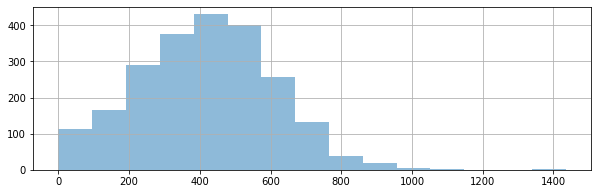

In [69]:
standart(data_smart['duration_sum'])

Среднее значение: 33.384028712427096
Медиана: 28.0
Дисперсия: 796.8129584480083
Стандартное отклонение: 28.22787555676141
Ожидаемое значение: 118.06765538271134


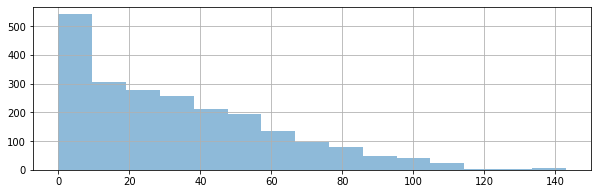

In [70]:
standart(data_smart['messages_count'])

Среднее значение: 16.328847016599372
Медиана: 17.0
Дисперсия: 33.02870517811161
Стандартное отклонение: 5.7470605685090534
Ожидаемое значение: 33.57002872212654


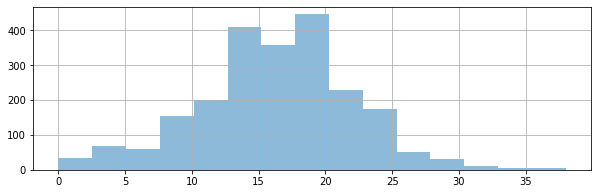

In [71]:
standart(data_smart['gb_user_sum'])

Среднее значение: 1289.9735307312696
Медиана: 1023.0
Дисперсия: 669785.7080064242
Стандартное отклонение: 818.4043670499469
Ожидаемое значение: 3745.1866318811108


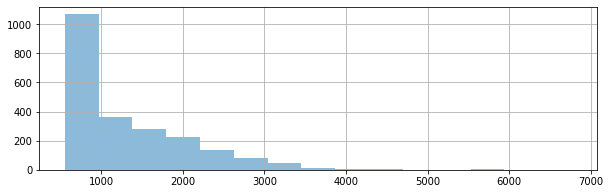

In [72]:
standart(data_smart['general_sum'])

Среднее значение: 526.6233502538071
Медиана: 518.0
Дисперсия: 100873.63339730098
Стандартное отклонение: 317.6060978591264
Ожидаемое значение: 1479.4416438311864


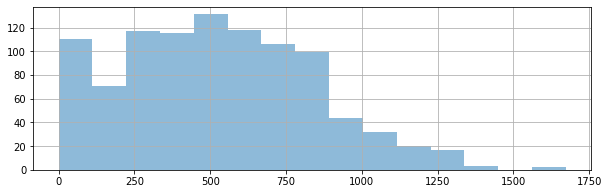

In [73]:
standart(data_ultra['duration_sum'])

Среднее значение: 49.36345177664975
Медиана: 38.0
Дисперсия: 2285.2661425446736
Стандартное отклонение: 47.804457350174715
Ожидаемое значение: 192.7768238271739


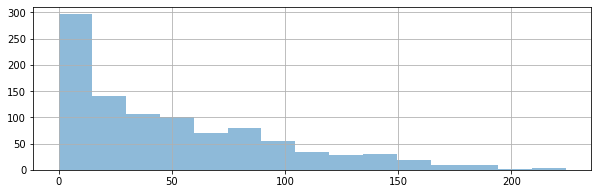

In [74]:
standart(data_ultra['messages_count'])

Среднее значение: 19.494416243654822
Медиана: 19.0
Дисперсия: 97.09168626965459
Стандартное отклонение: 9.853511367510293
Ожидаемое значение: 49.054950346185706


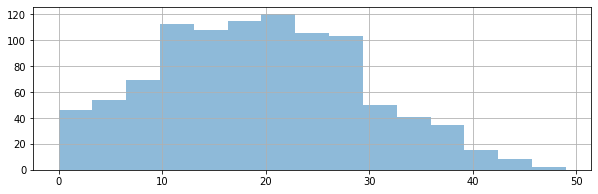

In [75]:
standart(data_ultra['gb_user_sum'])

Среднее значение: 2070.1522842639592
Медиана: 1950.0
Дисперсия: 141516.7450786183
Стандартное отклонение: 376.1871144505328
Ожидаемое значение: 3198.713627615558


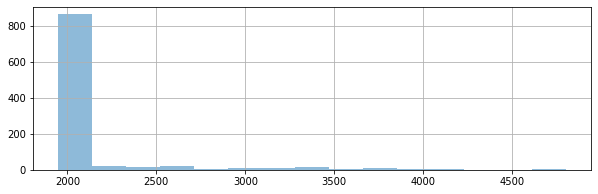

In [76]:
standart(data_ultra['general_sum'])

Для абонента тарифа `Smart` в месяц ожидаемое количество использование сотовой связи:
- 989 минут разговоров
- 118 смс
- 33 Гб интернет-трафика
- прибыль 3745 рублей в месяц.

Медиана значений значений, а именно стандартное поведение среднего абонента в месяц:
- 422 минуты разговоров
- 28 смс
- 17 Гб интернет-трафика
- расходы 1023 рубля в месяц.

Согласно гистаграммам, распределение значений находится в следующих диапазонах:
- большое количество абонентов тратят в месяц от 300 до 570 минут
- от 0 до 10 смс
- от 12 до 22 ГБ интернет-трафика
- расходуют в пределах 1050 рублей (что превышает стоимость тарифного плана в 2 раза)

Для абонента тарифа `Ultra` в месяц ожидаемое количество использование сотовой связи:
- 1480 минут разговоров
- 192 смс
- 49 Гб интернет-трафика
- прибыль 3200 рублей в месяц.

Медиана значений значений, а именно стандартное поведение среднего абонента в месяц:
- 518 минуты разговоров
- 19 смс
- 17 Гб интернет-трафика
- расходы 1950 рубля в месяц (в пределах тарифного плана).

Согласно гистаграммам, распределение значений находится в следующих диапазонах:
- большое количество абонентов тратят в месяц от 240 до 870 минут
- от 0 до 15 смс
- от 10 до 29 ГБ интернет-трафика
- расходы не превышают стоимости тарифного плана

## Гипотезы

1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Формируем двухстороннюю гипотезу `средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются`.**

Гипотеза будет звучать `Выручка пользователей тарифов «Смарт» равна выручке тарифа «Ультра». Альтернативная: выручки не равны.

Критический уровень статистической значимости укажем 5%

In [77]:
smart = data_smart['general_sum']
ultra = data_ultra['general_sum']

alpha = 0.05

results = st.ttest_ind(smart, ultra, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


**Вывод:** Гипотеза о равенстве средней выручке по двум тарифам отвергнута, соответственно средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

**Формируем гипотезу `средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов`.** 

В данном случае речь о равенстве средних для независимых (парных) выборок. 

In [78]:
moscow = data_good[data_good['city'] == 'Москва']['general_sum'].reset_index(drop=True)

In [79]:
moscow.shape[0]

611

In [80]:
outside_MKAD = data_good[data_good['city'] != 'Москва']['general_sum'].reset_index(drop=True)

In [81]:
outside_MKAD.shape[0]

2603

Гипотеза будет звучать `Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов`. Альтернативная: выручки не равны.

Критический уровень статистической значимости укажем 5%

Так как выборки у нас не одинаковые, укажим параметр `equal_var = False`

In [82]:
alpha = 0.05

results = st.ttest_ind(moscow, outside_MKAD, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Гипотеза о равенстве средней выручке абонентов Москвы и абонентов других городов не отвергнута, значит средняя выручка пользователей из Москвы скорее всего не отличается от выручки пользователей из других регионов.

In [83]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


## Вывод по проекту:
1. Входные данные: сведения о 500 пользователей и их использование сотовой связью в 5 отдельных датафреймах:
    - users (информация о пользователях)
    - calls (информация о звонках)
    - messages (информация о смс)
    - internet (информация об интернет-сессиях)
    - tariffs (информация о тарифах)
    
2. Проведена предобработка данных:
   * изменен тип данных, содержащих данные о датах,
   * добавлены столбцы, содержащие сведение о месяце;
   * пересчитаны сведения о минутах до целых чисел (округление в сторону увеличения);
   * в датафрейме тарифов мегабайты переведены в гигабайты.
   
3. Созданы датафреймы содержащие сгруппированные сведения звонках, смс-сообщениях и израсходованных мегабайтах за месяц по каждому пользователю, мегабайты израсходованные за месяц переведены в гигабайты с округлением в сторону увеличения.

4. Сгруппированные датафреймы объеденены в один общий `data`. Данный датафрейм содержит сведения о каждом абоненте и их ежемесячных действиях в сотовой связи.
    - удалены сведения о двух абонентах, у которых небыло совершено ни одной сессии;
    - пропуски заполнены 0
    
5. Создан датафрейм `data_good` путем слияния `data` и датафрейма `tariffs`:
    - добавлены сведения о тарифных планах (лимиты по звонкам, смс, интернет-трафике, стоимости превышения и сумме абонентской платы);
    - проведены расчеты по превышению тарифного плана, суммы переплаты и общей суммы выручки по каждому месяцу.
    
6. Сгруппирован датафрейм `data_good_group` с основными средними данными действий абонентов по тарифам, согласно которому:
    - тариф SMART принес за год больше прибыли сотовому оператору, чем ULTRA на 30%;
    - тариф SMART пользуется большей популярностью у абонентов, его использовали на 44% больше;
    - абоненты SMART чаще превышают оплаченный лимит по тарифу по звонкам, смс и интернет-трафику (1662 месяца из 2229);
    - абоненты тарифа ULTRA никогда не превышают количество минут и количество смс-сообщений, предусмотренных тарифом, редко по количеству интернет-трафика (134 месяца из 985);
    - средний расход абонента SMART на услуги сотовой связи сверх тарифа 740 рублей (общая сумма расхода с абонентской платой 1290 рублей);
    - средний расход абонента ULTRA на услуги сотовой связи сверх тарифа 121 рублей (общая сумма расхода с абонентской платой 2071 рублей);
    - При этом среднее количество минут/смс/ГБ на одного абонента в месяц:
        * SMART: 418 минут, 34 смс, 17 ГБ;
        * ULTRA: 527 минут, 50 смс, 20 ГБ.
    - Количество абонентов на тарифе Смарт, которые не использовали минуты - 8, не использовали смс: 307, которые не использовали ГБ: 0.
    - Количество абонентов на тарифе Ультра, которые не использовали минуты: 38, не использовали смс: 190, не использовали ГБ: 0.
7. Проведен расчет дисперсии, стандартного отклонения, медианы и ожидаемых значений по количеству минут, смс и ГБ интернет-трафика абонента в месяц по каждому тарифу:
    - Для абонента тарифа `Smart` в месяц ожидаемое количество использование сотовой связи:
        * 989 минут разговоров, 118 смс, 33 Гб интернет-трафика, прибыль 3745 рублей в месяц. 
    - Медиана значений значений, а именно стандартное поведение среднего абонента в месяц:
        * 422 минуты разговоров, 28 смс, 17 Гб интернет-трафика, расходы 1023 рубля в месяц.
    - Согласно гистаграммам, распределение значений находится в следующих диапазонах:
        * большое количество абонентов тратят в месяц от 300 до 570 минут, от 0 до 10 смс, от 12 до 22 ГБ интернет-трафика, расходуют в пределах 1050 рублей (что превышает стоимость тарифного плана в 2 раза).

    - Для абонента тарифа `Ultra` в месяц ожидаемое количество использование сотовой связи:
        * 1480 минут разговоров, 192 смс, 49 Гб интернет-трафика, прибыль 3200 рублей в месяц.
    - Медиана значений значений, а именно стандартное поведение среднего абонента в месяц:
        * 518 минуты разговоров, 19 смс, 17 Гб интернет-трафика, расходы 1950 рубля в месяц (в пределах тарифного плана).
    - Согласно гистаграммам, распределение значений находится в следующих диапазонах:
        * большое количество абонентов тратят в месяц от 240 до 870 минут, от 0 до 15 смс, от 10 до 29 ГБ интернет-трафика, расходы не превышают стоимости тарифного плана.
        
8. Сформированы и проверены гипотезы:
    -  Гипотеза о равенстве средней выручке по двум тарифам отвергнута, соответственно средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    - Гипотеза о равенстве средней выручке абонентов Москвы и абонентов других городов отвергнута, значит средняя выручка пользователей из Москвы скорее всего отличается от выручки пользователей из других регионов.

9. Предложения для сотового оператора:
Сейчас в наличии всего два тарифа, Смарт за 550 рублей и Ультра за 1990 рублей. Можно отметить, что оба эти тарифа не покрывают всей потребности абонентов, один слишком дорогой, второй маленький. 
- Абоненты тарифа Смарт более чем в 70% случаях превышают лимиты и тратят дополнительно 740 рублей. 
- Абоненты никогда не превышали лимиты Ультра, но цена данных тарифов отличается в 4 раза, соответственно абоненту дешевле купить тариф Смарт и доплатить в среднем еще 1,5 стоимости тарифа.

Необходимо разработать дополнительные тарифы 
* `Smapt +`:
    - 950 минут, 100 смс, 30 ГБ (данные расчитаны исходя из верхней границы нормального распределения данных) 
    - в ценовом диапазоне 1000 рублей.

Данный тариф будет отличной решением для большенства абонентов, кому тесно в Смарт, но нет желания переплачивать.
